<a href="https://colab.research.google.com/github/phantom-712/Liquid_crystal_project/blob/main/ChemBERTa_TgPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install transformers kaggle -q

# General imports
import pandas as pd
import numpy as np
import os
import zipfile
import re
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import AdamW
# Transformers (Hugging Face)
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from tqdm.auto import tqdm

Using device: cuda


In [ ]:
# Setup Kaggle API key (if needed)
# *** PLEASE UPLOAD YOUR 'kaggle.json' FILE IF YOU HAVEN'T ***
if not os.path.exists("/root/.kaggle/kaggle.json"):
    if not os.path.exists("kaggle.json"):
        print("Error: kaggle.json not found. Please upload it.")
    else:
        !mkdir -p /root/.kaggle
        !mv kaggle.json /root/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json

# Download and unzip (if needed)
data_file = "TgSS_enriched_cleaned.csv"
if not os.path.exists(data_file):
    print("Downloading dataset...")
    !kaggle datasets download -d linyeping/extra-dataset-with-smilestgpidpolimers-class -f TgSS_enriched_cleaned.csv
    try:
        with zipfile.ZipFile("TgSS_enriched_cleaned.csv.zip", 'r') as zip_ref:
            zip_ref.extractall(".")
        print("File unzipped successfully.")
    except Exception as e:
        print(f"Error unzipping file: {e}")
else:
    print("Dataset file already exists.")

Dataset file already exists.


In [ ]:
# --- Load Data ---
data_file = "TgSS_enriched_cleaned.csv"
df = pd.read_csv(data_file)

# 1. Clean data (same as before)
df_clean = df[['SMILES', 'Tg']].dropna().reset_index(drop=True)
df_clean['SMILES'] = df_clean['SMILES'].str.replace(r'\[\*\]', '', regex=True)
print(f"Cleaned data shape: {df_clean.shape}")

# 2. Define pre-trained model name
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# Load the pre-trained tokenizer
# This tokenizer knows how to split SMILES strings appropriately
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

# 3. Get Target Values (Tg) and standardize them
labels = df_clean['Tg'].values.astype(np.float32)
scaler = StandardScaler()
labels_scaled = scaler.fit_transform(labels.reshape(-1, 1))

# 4. Split data (80% train, 20% validation)
# We split the raw SMILES strings and scaled labels
X_train_smiles, X_val_smiles, y_train, y_val = train_test_split(
    df_clean['SMILES'].tolist(),
    labels_scaled,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train_smiles)}")
print(f"Validation samples: {len(X_val_smiles)}")

# Test the tokenizer
test_smile = X_train_smiles[0]
encoded = tokenizer(
    test_smile,
    padding=True,
    truncation=True,
    max_length=128
)
print(f"\nOriginal SMILES: {test_smile}")
print(f"Tokenized IDs: {encoded['input_ids']}")
print(f"Attention Mask: {encoded['attention_mask']}")

Cleaned data shape: (7284, 2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training samples: 5827
Validation samples: 1457

Original SMILES: *CCCN(C)c1ccc(C(=O)c2ccc(N(*)C)cc2)cc1
Tokenized IDs: [0, 14, 310, 12, 39, 13, 71, 21, 264, 12, 39, 263, 51, 13, 71, 22, 264, 12, 50, 12, 14, 13, 39, 13, 261, 22, 13, 261, 21, 2]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles = smiles_list
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # Return the raw string and the label
        return self.smiles[idx], self.labels[idx]

def create_collate_fn(tokenizer, max_len=128):
    def collate_fn(batch):
        # Separate the SMILES strings and labels
        smiles, labels = zip(*batch)

        # Tokenize the batch of SMILES strings
        # This handles padding and truncation for the whole batch
        inputs = tokenizer(
            list(smiles),
            return_tensors='pt',
            padding='max_length',  # Pad to the specified max_length
            truncation=True,
            max_length=max_len
        )

        # Stack labels into a single tensor
        labels = torch.stack(labels)

        return inputs, labels
    return collate_fn

# Create the collate function
collate_batch = create_collate_fn(tokenizer)

# Create Datasets
train_dataset = SMILESDataset(X_train_smiles, y_train)
val_dataset = SMILESDataset(X_val_smiles, y_val)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Train batches: 183
Validation batches: 46


In [ ]:
class ChemBERTaRegressor(nn.Module):
    def __init__(self, model_name, n_layers=2, hidden_dim=768, output_dim=1, dropout=0.3):
        super(ChemBERTaRegressor, self).__init__()

        # 1. Load the pre-trained ChemBERTa model
        self.chemberta = RobertaModel.from_pretrained(model_name)

        # Get the hidden size from the config (usually 768 for base models)
        config = self.chemberta.config
        self.hidden_size = config.hidden_size

        # 2. Define the new "regression head"
        # We take the [CLS] token's embedding and pass it through a small MLP
        self.regressor = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size // 2, output_dim)
        )

    def forward(self, input_ids, attention_mask):
        # Pass inputs through the ChemBERTa model
        # outputs.last_hidden_state shape: (batch_size, seq_length, hidden_size)
        outputs = self.chemberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # We use the embedding of the first token (the [CLS] or <s> token)
        # This token is designed to aggregate the sequence's meaning
        # cls_embedding shape: (batch_size, hidden_size)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass this embedding through our regression head to get a prediction
        prediction = self.regressor(cls_embedding)
        return prediction

# --- Instantiate model ---
model = ChemBERTaRegressor(MODEL_NAME).to(device)

print(f"Loaded {MODEL_NAME} and added regression head.")
# print(model) # Uncomment to see the full model architecture

Loaded seyonec/ChemBERTa-zinc-base-v1 and added regression head.


In [ ]:
# --- Training Configuration ---
# Transformers require fewer epochs for fine-tuning
NUM_EPOCHS = 10
# Transformer-specific learning rate
LEARNING_RATE = 2e-5
# Epsilon for AdamW optimizer
EPS = 1e-8

# Loss function for regression: Mean Squared Error
criterion = nn.MSELoss()

# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPS)

# Total steps for scheduler
total_steps = len(train_loader) * NUM_EPOCHS

# Create a learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Default, no warmup
    num_training_steps=total_steps
)

# Lists to store loss history for plotting
history = {'train_loss': [], 'val_loss': []}

print("Starting training...")

for epoch in tqdm(range(NUM_EPOCHS)):

    # --- Training Phase ---
    model.train()
    epoch_train_loss = 0.0

    for batch in train_loader:
        # Unpack batch and move to device
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # 1. Forward pass
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() # Update learning rate

        epoch_train_loss += loss.item()

    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad(): # Disable gradient calculation
        for batch in val_loader:
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)

            epoch_val_loss += loss.item()

    # --- Epoch Summary ---
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

print("Training finished!")

Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.3501 | Val Loss: 0.1984
Epoch [2/10] | Train Loss: 0.2004 | Val Loss: 0.1621
Epoch [3/10] | Train Loss: 0.1642 | Val Loss: 0.1461
Epoch [4/10] | Train Loss: 0.1406 | Val Loss: 0.1355
Epoch [5/10] | Train Loss: 0.1198 | Val Loss: 0.1368
Epoch [6/10] | Train Loss: 0.1089 | Val Loss: 0.1426
Epoch [7/10] | Train Loss: 0.0977 | Val Loss: 0.1308
Epoch [8/10] | Train Loss: 0.0906 | Val Loss: 0.1368
Epoch [9/10] | Train Loss: 0.0857 | Val Loss: 0.1332
Epoch [10/10] | Train Loss: 0.0826 | Val Loss: 0.1336
Training finished!


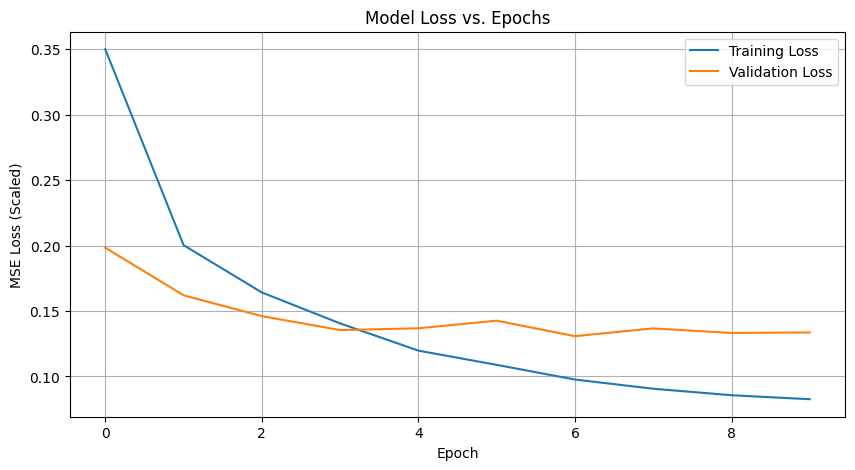

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

--- Final Model Evaluation (ChemBERTa) ---
R-squared (R²): 0.865
Mean Absolute Error (MAE): 28.45 °C

(MAE means our model's predictions are, on average,
 28.45 degrees off from the true value.)


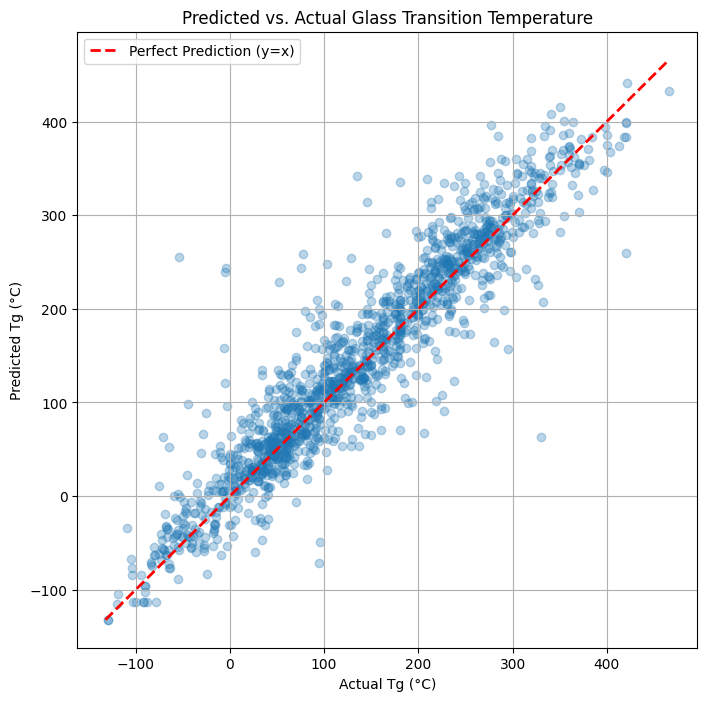

In [ ]:
model.eval()
all_preds_scaled = []
all_labels_scaled = []

with torch.no_grad():
    for batch in val_loader: # <--- Small update here
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        predictions = model(input_ids, attention_mask) # <--- And here

        all_preds_scaled.append(predictions.cpu())
        all_labels_scaled.append(labels.cpu())

# Concatenate all batches
all_preds_scaled = torch.cat(all_preds_scaled).numpy()
all_labels_scaled = torch.cat(all_labels_scaled).numpy()

# --- CRITICAL: Inverse transform to original scale (Celsius) ---
all_preds_actual = scaler.inverse_transform(all_preds_scaled)
all_labels_actual = scaler.inverse_transform(all_labels_scaled)

# --- Calculate Metrics ---
r2 = r2_score(all_labels_actual, all_preds_actual)
mae = mean_absolute_error(all_labels_actual, all_preds_actual)

print(f"--- Final Model Evaluation (ChemBERTa) ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print("\n(MAE means our model's predictions are, on average,")
print(f" {mae:.2f} degrees off from the true value.)")


# --- Plot Predicted vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(all_labels_actual, all_preds_actual, alpha=0.3)
# Add a y=x line (perfect prediction)
plt.plot([min(all_labels_actual.min(), all_preds_actual.min()),
          max(all_labels_actual.max(), all_preds_actual.max())],
         [min(all_labels_actual.min(), all_preds_actual.min()),
          max(all_labels_actual.max(), all_preds_actual.max())],
         'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Predicted vs. Actual Glass Transition Temperature')
plt.xlabel('Actual Tg (°C)')
plt.ylabel('Predicted Tg (°C)')
plt.legend()
plt.grid(True)
plt.show()